## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo 6 - Redes neurais para dados sequenciais</span>

#### <span style="color:darkred">**Parte 1: LSTMs e GRUs**</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [2]:
import numpy as np
from pandas import read_csv
from pandas import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from numpy.random import seed
from tensorflow.random import set_seed

from sklearn.metrics import mean_squared_error
from math import sqrt

# outros 
#df = read_csv('Alcohol_Sales.csv') 
#df = read_csv('Miles_Traveled.csv')
#df = read_csv('starbucks.csv') 
#df = read_csv('passengers.csv')
df = read_csv('data/price_of_ground_chuck.csv') 

# pega segunda coluna do dataframe
var = df.columns.values[1]

porc_treinamento = 70
inserir_ruido_serie = False
inserir_ruido_teste = True
porc_ruido = 10

<ipython-input-2-5d6f2217cdd6>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Série:  Price
Tamanho da série:  241


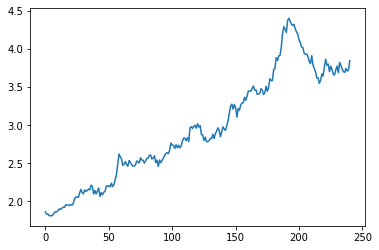

In [3]:
series = np.array(df[var])
plt.plot(series)
N = series.shape[0]

print("Série: ", var)
print("Tamanho da série: ", N)

Exemplos de Treinamento:  168
Exemplos de Teste:  72


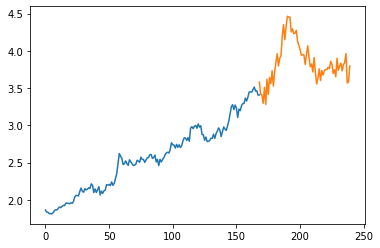

In [4]:
# calcula tamanhos dos dados de treinamento (n1) e teste (n2)
n1 = int(series.shape[0]*(porc_treinamento/100.0))
n2 = int(series.shape[0]*(1-(porc_treinamento/100.0)))

seed(1)
set_seed(1)

# insere ruido na serie
if (inserir_ruido_serie):
    series = series + np.random.randn(N)*(porc_ruido/100.0)

# divide dados de treinamento e teste
train, test = series[0:-n2], series[-n2:]

# insere ruido apenas no teste
if (inserir_ruido_teste):
    test = test + np.random.randn(n2)*(porc_ruido/100.0)

print("Exemplos de Treinamento: ", n1)
print("Exemplos de Teste: ", n2)
plt.plot(np.arange(0, n1+1), train)
plt.plot(np.arange(n1,n1+n2), test)

### Parte 1: Preparando os dados

#### a) Problema de aprendizado supervisionado
Podemos cumprir essa etapa utilizando a observação do último passo $t-1$ como entrada e a observação atual $t$ como saída.

Podemos alcançar isso empurrando todos os valores da série por um número específico de posições. Aqui vamos deslocar 1 posição para trás, que se tornarão as variáveis de entrada, sendo que a série temporal original será considerada como a variável de saída.

#### b) Normalização

Redes neurais não funcionam bem com dados não normalizados. Aqui utilizaremos a normalização Min-Max para 0-1


In [5]:
# modifica uma serie temporal tornando-a
# um problema de aprendizado supervisionado
def timeseries_to_supervised(series, look_back=1):
  x = series[:-look_back]
  y = np.array(series[look_back:], copy=True)
  return x,y

def normalize(train, test):
    d_max = np.max(train)
    d_min = np.min(train)		
    return ((train - d_min) / (d_max-d_min)), ((test - d_min) / (d_max-d_min))

In [6]:
look_back = 1

n_train, n_test = normalize(train, test)

x_train, y_train = timeseries_to_supervised(n_train, look_back)
x_test, y_test = timeseries_to_supervised(n_test, look_back)

#mostrando exemplos
print(x_train[:4])
print(y_train[:4])
print("Dados treinamento após conversao: ", x_train.shape)
print("Dados teste após conversao: ", x_test.shape)


[0.03051643 0.01408451 0.01349765 0.00117371]
[0.01408451 0.01349765 0.00117371 0.00293427]
Dados treinamento após conversao:  (168,)
Dados teste após conversao:  (71,)


## Utilizando unidades Densas para predição

Vamos tentar aprender a partir da série para obter um tipo de regressão

In [7]:
seed(2)
set_seed(2)

MLP = keras.Sequential()
MLP.add(keras.layers.Dense(32, input_shape=(1,)))
MLP.add(keras.layers.Dropout(0.2))
MLP.add(keras.layers.Dense(1))

In [8]:
batch_size = 1
epochs = 50
MLP.compile(loss='mean_squared_error', 
            optimizer=keras.optimizers.Adam(lr=0.001),
            metrics=['mae'])
histMLP = MLP.fit(x_train, y_train,  
                  batch_size=batch_size, epochs=epochs, 
                  verbose=0)

In [9]:
# make predictions
mlpTrain = MLP.predict(x_train)
mlpTest = MLP.predict(x_test)

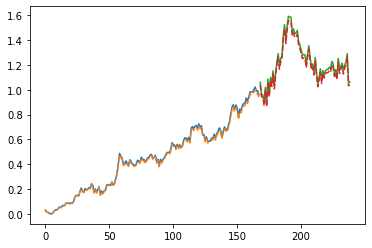

In [10]:
plt.plot(mlpTrain)
plt.plot(x_train,'--')

plt.plot(np.arange(n1,n1+n2-1), mlpTest)
plt.plot(np.arange(n1,n1+n2-1), x_test,'--')

Vamos por a teste a capacidade do modelo de predições de longo prazo

In [11]:
mlpSeqTest = np.zeros(x_test.shape[0]-1)
mlpSeqTest[0] = x_test[0]
print("Exemplo inicial: ", mlpSeqTest[0])

passos = 6
for i in np.arange(1, x_test.shape[0]-1):
    if (i % passos == 0):
        mlpSeqTest[i] = x_test[i]
    else:
        mlpSeqTest[i] = MLP.predict([mlpSeqTest[i-1]])

Exemplo inicial:  1.0384005495107536


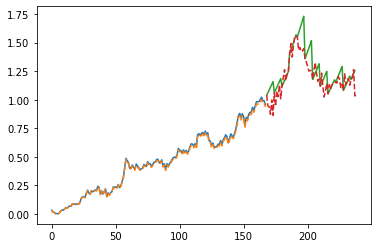

In [12]:
plt.plot(mlpTrain)
plt.plot(x_train,'--')

plt.plot(np.arange(n1,n1+n2-2), mlpSeqTest)
plt.plot(np.arange(n1,n1+n2-1), x_test,'--')

## Utilizando LSTMs para predição

Agora utilizaremos uma rede neural baseada em camada recorrente, permitindo aprender a sequência.

Uma camada LSTM espera como entrada uma matriz com as seguintes dimensões:

samples x time_steps x features

* *Samples* são as observações independentes do domínio, tipicamente colunas de dados, consideradas no batch

* *Time steps* são os passos temporais separados de uma dada variável para uma dada observação - quantas observações serão dadas como entrada antes de que a primeira saída seja obtida

* *Features* são as medidas separadas observada em cada tempo da observação - quantos valores são considerados em cada entrada

No caso dessa base de dados, podemos usar diferentes configurações. Para manter simples, consideramos que o problema em cada passo de tempo é uma amostra individual, com um time step e uma feature apenas.


In [13]:
# formato deve ser [samples, time steps, features]
lstm_train = np.reshape(x_train, (x_train.shape[0], 1, 1))
lstm_test = np.reshape(x_test, (x_test.shape[0], 1, 1))
print(lstm_train[:4])
print(lstm_train.shape)

[[[0.03051643]]

 [[0.01408451]]

 [[0.01349765]]

 [[0.00117371]]]
(168, 1, 1)


## Rede LSTM

Definimos o número de neurônios, ou seja a quantidade de unidades de memória, ex. 1 a 5.

In [14]:
neurons = 16
batch_size = 1

seed(2)
set_seed(2)
modelLSTM = keras.models.Sequential()
modelLSTM.add(keras.layers.LSTM(neurons, input_shape=(1,1)))
modelLSTM.add(keras.layers.Dropout(0.2))
modelLSTM.add(keras.layers.Dense(1))
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [15]:

modelLSTM.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['mae'])

histLSTM = modelLSTM.fit(lstm_train, y_train, epochs=epochs, 
              batch_size=batch_size, 
              verbose=0, shuffle=False)

In [16]:
# realiza predicoes
lstmTrain = modelLSTM.predict(lstm_train)
lstmTest = modelLSTM.predict(lstm_test)

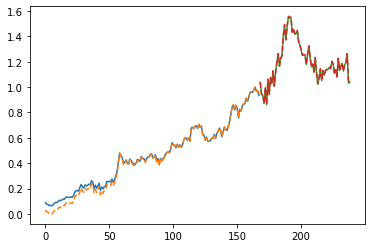

In [17]:
plt.plot(lstmTrain)
plt.plot(x_train,'--')

plt.plot(np.arange(n1,n1+n2-1), lstmTest)
plt.plot(np.arange(n1,n1+n2-1), x_test,'--')

In [18]:
LSTMSeqTest = np.zeros(lstmTest.shape[0]-1)
LSTMSeqTest[0] = lstmTest[0]
print("Exemplo inicial: ", LSTMSeqTest[0])

for i in np.arange(1, lstmTest.shape[0]-1):
    if (i % passos == 0):
        LSTMSeqTest[i] = lstmTest[i]
    else:
        LSTMSeqTest[i] = modelLSTM.predict(LSTMSeqTest[i-1].reshape(1,1,1))

Exemplo inicial:  1.0367884635925293


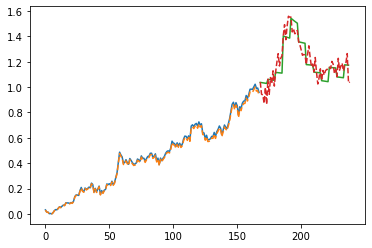

In [19]:
plt.plot(mlpTrain)
plt.plot(x_train,'--')

plt.plot(np.arange(n1,n1+n2-2), LSTMSeqTest)
plt.plot(np.arange(n1,n1+n2-1), x_test,'--')

### GRU como forma alternativa à LSTM

In [20]:
neurons = 16
batch_size = 1

seed(2)
set_seed(2)
modelGRU = keras.models.Sequential()
modelGRU.add(keras.layers.GRU(neurons, input_shape=(1,1)))
modelGRU.add(keras.layers.Dropout(0.2))
modelGRU.add(keras.layers.Dense(1))
modelGRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                912       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [21]:
modelGRU.compile(loss='mean_squared_error', 
                 optimizer=keras.optimizers.Adam(lr=0.001),
                 metrics=['mae'])

histGRU = modelGRU.fit(lstm_train, y_train, epochs=epochs, 
             batch_size=batch_size, 
             verbose=0, shuffle=False)

In [22]:
# realiza predicoes
gruTrain = modelGRU.predict(lstm_train)
gruTest = modelGRU.predict(lstm_test)

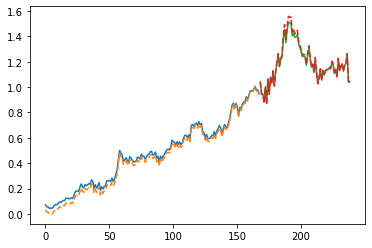

In [23]:
plt.plot(gruTrain)
plt.plot(x_train,'--')

plt.plot(np.arange(n1,n1+n2-1), gruTest)
plt.plot(np.arange(n1,n1+n2-1), x_test,'--')

In [24]:
GRUSeqTest = np.zeros(lstm_test.shape[0]-1)
GRUSeqTest[0] = lstm_test[0]
print("Exemplo inicial: ", GRUSeqTest[0])

for i in np.arange(1, lstm_test.shape[0]-1):
    if (i % passos == 0):
        GRUSeqTest[i] = lstm_test[i]
    else:
        GRUSeqTest[i] = modelGRU.predict(GRUSeqTest[i-1].reshape(1,1,1))

Exemplo inicial:  1.0384005495107536


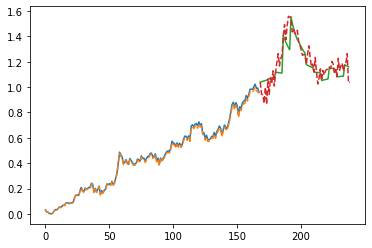

In [25]:
plt.plot(mlpTrain)
plt.plot(x_train,'--')

plt.plot(np.arange(n1,n1+n2-2), GRUSeqTest)
plt.plot(np.arange(n1,n1+n2-1), x_test,'--')

Comparação entre os 3 modelos

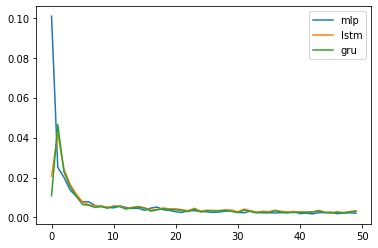

In [26]:
plt.plot(histMLP.history['loss'])
plt.plot(histLSTM.history['loss'])
plt.plot(histGRU.history['loss'])
plt.legend(['mlp', 'lstm', 'gru'])

In [27]:
# avaliacao da predição ponto a ponto

print("Erro no teste com predição a cada ponto:")
scoreMLP = MLP.evaluate(x_test, y_test, verbose=0)
print("MLP: %.5f" % (scoreMLP[1]))
scoreLSTM = modelLSTM.evaluate(lstm_test, y_test, verbose=0)
print("LSTM: %.5f" % (scoreLSTM[1]))
scoreGRU = modelGRU.evaluate(lstm_test, y_test, verbose=0)
print("GRU: %.5f" % (scoreGRU[1]))


Erro no teste com predição a cada ponto:
MLP: 0.07132
LSTM: 0.06828
GRU: 0.06813


Avaliação da memória dos modelos

In [33]:
from sklearn.metrics import mean_absolute_error

print("Erro com memória de %d pontos:" % (passos-1))
mseMLP = mean_absolute_error(y_test[:-1], mlpSeqTest)
print("MLP: %.5f" % (mseMLP))
mseLSTM = mean_absolute_error(y_test[:-1], LSTMSeqTest)
print("LSTM: %.5f" % (mseLSTM))
mseGRU = mean_absolute_error(y_test[:-1], GRUSeqTest)
print("GRU: %.5f" % (mseGRU))

Erro com memória de 5 pontos:
MLP: 0.10253
LSTM: 0.08507
GRU: 0.07864


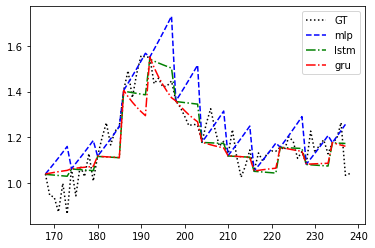

In [34]:
plt.plot(np.arange(n1,n1+n2-1), x_test,'k:')
plt.plot(np.arange(n1,n1+n2-2), mlpSeqTest, 'b--')
plt.plot(np.arange(n1,n1+n2-2), LSTMSeqTest, 'g-.')
plt.plot(np.arange(n1,n1+n2-2), GRUSeqTest, 'r-.')
plt.legend(['GT', 'mlp', 'lstm', 'gru'])